# ITMAL Exercise

REVISIONS| |
---------| |
2018-0301| CEF, initial.
2018-0305| CEF, updated.
2018-0306| CEF, updated and spell checked.
2018-0306| CEF, major overhaul of functions.
2018-0306| CEF, fixed problem with MNIST load and Keras.
2018-0307| CEF, modified report functions and changed Qc+d.
2018-0311| CEF, updated Qd.
2018-0312| CEF, added grid and random search figs and added bullets to Qd.
2018-0313| CEF, fixed SVC and gamma issue, and changed dataload to be in fetchmode (non-keras).
2019-1015| CEF, updated for ITMAL E19
2019-1019| CEF, minor text update.
2019-1023| CEF, changed demo model i Qd) from MLPClassifier to SVC.

## Hyperparameters and Gridsearch 

When instantiating a Scikit-learn model in python most or all constructor parameters have _default_ values. These values are not part of the internal model and are hence called ___hyperparametes___---in contrast to _normal_ model parameters, say the weights, $\mathbf w$, for an `SGD` model.

An example could be the python constructor for the support-vector classifier `sklearn.svm.SVC`, with, say the `kernel` hyperparameter having the default value `'rbf'`. If you should choose, what would you set it to other than `'rbf'`? 

```python
class sklearn.svm.SVC(
    C=1.0, 
    kernel=’rbf’, 
    degree=3,
    gamma=’auto_deprecated’, 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight=None, 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape=’ovr’, 
    random_state=None
  )
```  

The default values might be sensible a general starting point, but for your data, you might want to optimize the hyperparameters to yield a better result. 

To be able to set `kernel` to a sensible value you need to go into the documentation for the `SVC` and understand what the kernel parameter represents and what values it can be set to, and you need to understand the consequences of setting `kernel` to something different than the default...and the story repeats for every other hyperparameter!

An alternative is just to __brute-force__ a search of interesting hyperparameters, an choosing the 'best' parameters according to a fit-predict and some performance metric, say 'f1'. 

Now, you just pick out some hyperparameters, that you figure are important, set them to a suitable range, say

```python
    'kernel':('linear', 'rbf'), 
    'C':[1, 10]
```
and fire up a full (grid) search on this hyperparameter set, that will try out all combination of `kernel` and `C` for the model, and then prints the hyperparameter set with the highest score...

<img src="https://itundervisning.ase.au.dk/E19_itmal/L08/Figs/gridsearch.png" style="width:350px">
<small><em>
    <center> Conceptual graphical view of grid search for two distinct hyperparameters. </center> 
    <center> Notice that you would normally search hyperparameters like `alpha` with an exponential range, say [0.01, 0.1, 1, 10] or similar.</center>
</em></small>

The demo code below sets up some of our well known 'hello-world' data and run a _grid search_ on a particular model, here a _support-vector classifier_ (SVC)

Other models and datasets  ('mnist', 'iris', 'moon') can also be examined.

### Qa Explain GridSearchCV

There are two code cells below: 1:) function setup, 2) the actual grid-search.

Review the code cells and write a __short__ summary. Mainly focus on __cell 2__, but dig into cell 1 if you find it interesting (notice the use of local-function, a nifty feature in python).
  
In detail, examine the lines:  
  
```python
grid_tuned = GridSearchCV(model, tuning_parameters, ..
grid_tuned.fit(X_train, y_train)
..
FullReport(grid_tuned , X_test, y_test, time_gridsearch)
```
and write a short description of how the `GridSeachCV` works: explain how the search parameter set is created and the overall search mechanism is functioning (without going into to much detail).

What role does the parameter `scoring='f1_micro'` play in the `GridSearchCV`, and what does `n_jobs=-1` mean? 

NOTICE: you need the dataloader module from `libitmal`, clone 
```
> git clone https://cfrigaard@bitbucket.org/cfrigaard/itmal

```
or pull the GIT repository to get the latest version, and put `libitmal` into the python path.

In [1]:
# TODO: Qa, code review..cell 1) function setup

from time import time
import numpy as np

from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import datasets

from libitmal import dataloaders_v3 as itmaldataloaders

currmode="N/A" # GLOBAL var!

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            r=""          
            for key in sorted(best_params):
                value = best_params[key]
                t = "'" if str(type(value))=="<class 'str'>" else ""
                if len(r)>0:
                    r += ','
                r += f'{key}={t}{value}{t}'  
            return r            
        try:
            p = GetParams(best_params)
            return type(model).__name__ + '(' + p + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel
    
def LoadAndSetupData(mode, test_size=0.3):
    assert test_size>=0.0 and test_size<=1.0
    
    def ShapeToString(Z):
        n = Z.ndim
        s = "("
        for i in range(n):
            s += f"{Z.shape[i]:5d}"
            if i+1!=n:
                s += ";"
        return s+")"

    global currmode
    currmode=mode
    print(f"DATA: {currmode}..")
    
    if mode=='moon':
        X, y = itmaldataloaders.MOON_GetDataSet(n_samples=5000, noise=0.2)
        itmaldataloaders.MOON_Plot(X, y)
    elif mode=='mnist':
        X, y = itmaldataloaders.MNIST_GetDataSet(fetchmode=True, debug=True)
        if X.ndim==3:
            X=np.reshape(X, (X.shape[0], -1))
    elif mode=='iris':
        X, y = itmaldataloaders.IRIS_GetDataSet()
    else:
        raise ValueError(f"could not load data for that particular mode='{mode}'")
        
    print(f'  org. data:  X.shape      ={ShapeToString(X)}, y.shape      ={ShapeToString(y)}')

    assert X.ndim==2
    assert X.shape[0]==y.shape[0]
    assert y.ndim==1 or (y.ndim==2 and y.shape[1]==0)    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, shuffle=True
    )
    
    print(f'  train data: X_train.shape={ShapeToString(X_train)}, y_train.shape={ShapeToString(y_train)}')
    print(f'  test data:  X_test.shape ={ShapeToString(X_test)}, y_test.shape ={ShapeToString(y_test)}')
    print()
    
    return X_train, X_test, y_train, y_test

print('OK')

Using TensorFlow backend.


OK


In [2]:
# TODO: Qa, code review..cell 2) the actual grid-search

# Setup data
X_train, X_test, y_train, y_test = LoadAndSetupData('iris') # 'iris', 'moon', or 'mnist'

# Setup search parameters
model = svm.SVC(gamma=0.001) # NOTE: gamma="scale" does not work in older Scikit-learn frameworks, 
                             # FIX:  replace with model = svm.SVC(gamma=0.001)

tuning_parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[1, 10]
}

CV=5
VERBOSE=0

# Run GridSearchCV for the model
start = time()
grid_tuned = GridSearchCV(model, tuning_parameters, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
grid_tuned.fit(X_train, y_train)
t = time()-start

# Report result
b0, m0= FullReport(grid_tuned , X_test, y_test, t)
print('OK')

DATA: iris..
  org. data:  X.shape      =(  150;    4), y.shape      =(  150)
  train data: X_train.shape=(  105;    4), y_train.shape=(  105)
  test data:  X_test.shape =(   45;    4), y_test.shape =(   45)

SEARCH TIME: 6.24 sec

Best model set found on train set:

	best parameters={'C': 1, 'kernel': 'linear'}
	best 'f1_micro' score=0.9714285714285714
	best index=0

Best estimator CTOR:
	SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.971 (+/-0.048) for {'C': 1, 'kernel': 'linear'}
	[ 1]: 0.695 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
	[ 2]: 0.952 (+/-0.084) for {'C': 10, 'kernel': 'linear'}
	[ 3]: 0.914 (+/-0.111) for {'C': 10, 'kernel': 'rbf'}

Detailed classification report:
	The model is trained on the full development set.
	The scores are comput

<h3 style='color:green'>Qa) Answers</h3>

#### If you should choose, what would you set it to other than 'rbf'?

Another svm.SVC Parameter/Hyperparameter for replacing Kernel's default rbf, could be: 'poly' or the fast-performing 'linear'.

#### Cell 1 code review

Here we have the function setup cell, most important parts here are the imported dataloaders, which have the datasets used, and then the LoadAndSetupData which trains the selected dataset (passed as parameter from cell 2). Other than that we have functions to validate stuff like the various hyperparameters used in the actual grid-search, and also, we have print "prettifiers", so the printed report holds all relevant data needed to get some feedback to the user on the results.

#### Cell 2 code review

We start here by getting the train and test data from LoadAndSetupData().<br>
Then we create our model with given search parameters, in this case SVC is used.<br>
Next we have our tuning_parameters, each key/value pair here represents a feature/dimension in our grid search. So in this 2-dimensional grid search we have the simple pattern of taking the first value from the first key and run that against each value in the second key. This process repeats for the next value in the first key and so on, ending up with, as the word states, a grid search.<br>
We then start a timer, run the actual grid search with our model and tuning_parameters, fit this to our train data, and finally stop the timer.<br>
We end this cell by printing out a full report with all the results.

##### Short explanation on the various parameters used in our Grid Search follows:
1. **model:** svm.SVC(gamma=0.001)
2. **tuning_parameters:** ('linear', 'rbf') for our kernel, and [1, 10] for our penalty parameter C.
3. **cv:** is set to 5-fold (new default in v0.22), which is the cross-validation splitting strategy.
4. **scoring:** here 'f1_micro' is used also known as balanced F-score or F-measure, this calculate metrics globally by counting the total true positives, false negatives and false positives.
5. **verbose:** here set to 0 to control verbosity (0 = no messages).
6. **n_jobs:** controls the number of jobs running in parallel, default is none (1), and when setting it to -1, as it has been set here, it means running on all processors.
7. **iid:** If True, return the average score across folds, weighted by the number of samples in each test set.

This should wrap up cell 2 review.

### Qb Hyperparameter Grid Search using an SDG classifier

Now, replace the `svm.SVC` model with an `SGDClassifier` and a suitable set of the hyperparameters for that model.

You need at least four or five different hyperparameters from the `SDG` in the search-space before it begins to take considerable compute time doing the full grid search.

DATA: moon..
  org. data:  X.shape      =( 5000;    2), y.shape      =( 5000)
  train data: X_train.shape=( 3500;    2), y_train.shape=( 3500)
  test data:  X_test.shape =( 1500;    2), y_test.shape =( 1500)

SEARCH TIME: 9.58 sec

Best model set found on train set:

	best parameters={'alpha': 0.0001, 'learning_rate': 'constant', 'penalty': 'elasticnet', 'power_t': 0.1}
	best 'f1_micro' score=0.8654285714285714
	best index=88

Best estimator CTOR:
	SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='log',
              max_iter=1000000.0, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.1, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.849 (+/-0.013) for {'alpha': 1e-05, 'learn

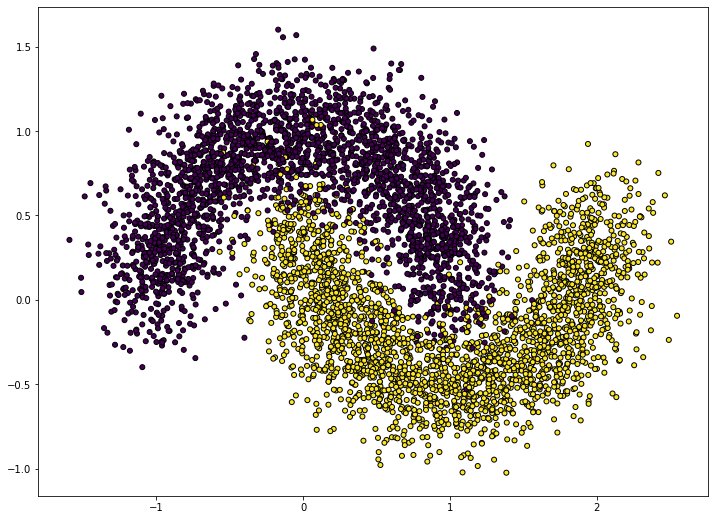

In [3]:
# Setup data
X_train, X_test, y_train, y_test = LoadAndSetupData('moon') # 'iris', 'moon', or 'mnist'

# Setup search parameters
model = SGDClassifier(eta0=0.1, loss='log', max_iter=1e6)

tuning_parameters = {
    'learning_rate':('optimal' ,'constant' ,'invscaling', 'adaptive'),
    'penalty':('l2', 'l1', 'elasticnet'),
    'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'power_t':[0, 1e-3, 1e-2, 1e-1, 1]
}


CV=5
VERBOSE=0

# Run GridSearchCV for the model
start = time()
grid_tuned = GridSearchCV(model, tuning_parameters, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
grid_tuned.fit(X_train, y_train)
t = time()-start

# Report result
b0, m0= FullReport(grid_tuned , X_test, y_test, t)
print('OK')

### Qc Hyperparameter Random  Search using an SDG classifier

Now, add code to run a `RandomizedSearchCV` instead.

<img src="https://itundervisning.ase.au.dk/E19_itmal/L08/Figs/randomsearch.png" style="width:350px">
<small><em>
    <center> Conceptual graphical view of randomized search for two distinct hyperparameters. </center> 
</em></small>

Use the same parameters for the random search, but add and investigate the new `n_iter` parameter

```python
random_tuned = RandomizedSearchCV(
    model, 
    tuning_parameters, 
    random_state=42, 
    n_iter=20, 
    cv=CV, 
    scoring='f1_micro', 
    verbose=VERBOSE, 
    n_jobs=-1, 
    iid=True)
```

Comparison of time (seconds) to complete `GridSearch` versus `RandomizedSearchCV`, does not necessarily give any sense, if your grid search completes in a few seconds (as for the iris tiny-data). You need a search that runs for minute, hours, or days.

But you could compare the best-tuned parameter set and best scoring for the two methods. Is the random search best model close to the grid search?  

DATA: moon..
  org. data:  X.shape      =( 5000;    2), y.shape      =( 5000)
  train data: X_train.shape=( 3500;    2), y_train.shape=( 3500)
  test data:  X_test.shape =( 1500;    2), y_test.shape =( 1500)

SEARCH TIME: 9.51 sec

Best model set found on train set:

	best parameters={'power_t': 0.01, 'penalty': 'elasticnet', 'learning_rate': 'invscaling', 'alpha': 0.0001}
	best 'f1_micro' score=0.8674285714285714
	best index=102

Best estimator CTOR:
	SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='invscaling', loss='log',
              max_iter=1000000.0, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.01, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.845 (+/-0.026) for {'power_t': 0, '

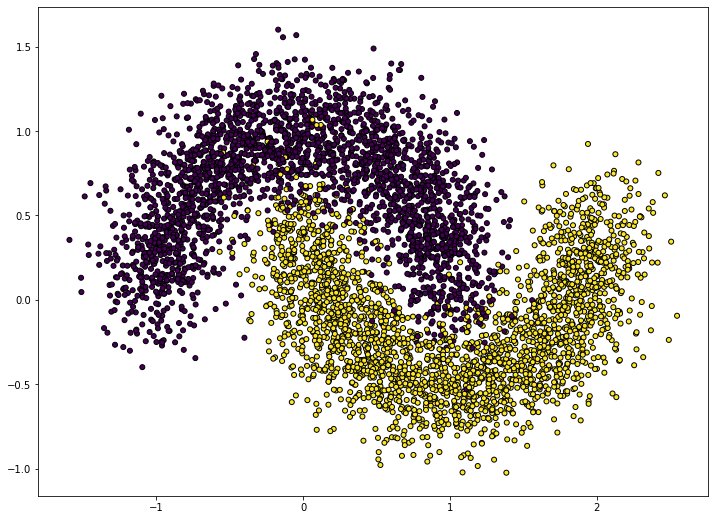

In [4]:
# Setup data
X_train, X_test, y_train, y_test = LoadAndSetupData('moon') # 'iris', 'moon', or 'mnist'

# Setup search parameters
model = SGDClassifier(eta0=0.1, loss='log', max_iter=1e6)

tuning_parameters = {
    'learning_rate':('optimal' ,'constant' ,'invscaling', 'adaptive'),
    'penalty':('l2', 'l1', 'elasticnet'),
    'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'power_t':[0, 1e-3, 1e-2, 1e-1, 1]
}


CV=5
VERBOSE=0
N_ITER=360
RNDS=42

# Run GridSearchCV for the model
start = time()
grid_tuned = RandomizedSearchCV(model, tuning_parameters, random_state=RNDS, n_iter=N_ITER, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
grid_tuned.fit(X_train, y_train)
t = time()-start

# Report result
b0, m0= FullReport(grid_tuned , X_test, y_test, t)
print('OK')

### Qc answer

The best model in the grid search was:

Best model set found on train set:

	best parameters={'alpha': 0.01, 'learning_rate': 'invscaling', 'penalty': 'l1', 'power_t': 0.01}
	best 'f1_micro' score=0.8662857142857143
	best index=217
    
The best model in the randomised search was:

Best model set found on train set:

	best parameters={'power_t': 0.01, 'penalty': 'l1', 'learning_rate': 'optimal', 'alpha': 0.0001}
	best 'f1_micro' score=0.8685714285714285
	best index=67
    
The only difference in parameters is alpha. The randomized search finds the best solution, though they are very close.

### Qd MNIST Search Quest II

Finally, we create yet a search-quest competition: who can find the best model+hyperparameters for MNIST dataset?

You change to the MNIST data by calling `LoadAndSetupData('mnist')`, and this is a completely other ball-game that the _tiny-data_ iris: it's much larger (but still far from _big-data_)!

* You might opt for an exhaustive grid search, or a faster but-less optimal random search...your choice. 

* You are free to pick any classifier in Scikit-learn, even algorithms we have not discussed yet---except Neural Networks!. Keep the score function at `f1_micro`, otherwise, we will be comparing 'æbler og pærer'. 

* And, you may also want to scale you input data for some models to perform better (neural networks in particular).

* DO NOT USE any Neural Network models, including Keras or Tensorflow models...not yet, and there are too many examples on the net to cut-and-paste from!

Check your result by printing the first _return_ value from `FullReport()` 
```python 
b1, m1 = FullReport(random_tuned , X_test, y_test, time_randomsearch)
print(b1)
```
that will display a result like
```
best: dat=iris, score=0.97143, model=SVC(C=1, kernel='linear')
```
Now, check if your score (for MNIST) is better that the currently best score on Blackboard: "L07: Optimization and searching" | "Search Quest for MNIST"

> https://blackboard.au.dk/webapps/blackboard/content/listContentEditable.jsp?content_id=_2302642_1&course_id=_131051_1&mode=reset

and paste your best model into the message box, like
```
best(Grp99): dat=mnist, score=0.47090, model=SVC(C=1, kernel='linear')
```
Remember to provide a ITMAL group name manually, so we can identify a winnner: the 1.st price is yet a cake! 

For the handin, report your progress in scoring choosing different models, hyperparameters to search and how you might need to preprocess your data...

In [5]:
# Setup data
X_train, X_test, y_train, y_test = LoadAndSetupData('mnist') # 'iris', 'moon', or 'mnist'


DATA: mnist..
MNIST_GetDataSet(), in fetchmode, using fetch_openml()...
  org. data:  X.shape      =(70000;  784), y.shape      =(70000)
  train data: X_train.shape=(49000;  784), y_train.shape=(49000)
  test data:  X_test.shape =(21000;  784), y_test.shape =(21000)



In [ ]:
# Setup search parameters
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier() # TODO: Choose a different model!

tuning_parameters = {
    'n_neighbors ':[3,5,10,20],
    'algorithm': ('ball_tree','auto')
}


CV=5
VERBOSE=1
N_ITER=4
RNDS=42

# Run GridSearchCV for the model
start = time()
grid_tuned = GridSearchCV(model, tuning_parameters, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
grid_tuned.fit(X_train, y_train)
t = time()-start

# Report result
b1, m1 = FullReport(grid_tuned, X_test, y_test, t)
print('OK')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


We tried different models (SGDclassifier, SVM, KNN), but the execution time was too long and we ran out of time :'(